In [1]:
# ==========================================================
# BLOCCO 1 ✅ DEFINITIVO
# Lettura dataset compressi + Preprocessing etichette
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("📂 Caricamento dataset compressi...")

# === Lettura file .npz generato nel BLOCCO 11 ===
data_npz = np.load(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_bal.npz", allow_pickle=True)

# === Estrazione dei dataset ===
X_train = data_npz["X_train"]
X_test = data_npz["X_test"]
y_train = data_npz["y_train"]
y_test = data_npz["y_test"]

# === Dataset bilanciato opzionale ===
X_train_bal = data_npz["X_train_bal"]
y_train_bal = data_npz["y_train_bal"]

print("✅ Dataset caricati con successo dal file .npz\n")

# === Conversione etichette (da stringhe a numeri) ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_bal_enc = le.transform(y_train_bal)

# === Info riepilogative ===
print("📊 Dimensioni:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}  | y_test : {y_test.shape}")
print(f"X_train_bal: {X_train_bal.shape} | y_train_bal: {y_train_bal.shape}")

print("\n🔢 Classi trovate:", list(le.classes_))
print("Numero classi:", len(le.classes_))

# === Verifica che tutto sia numerico ===
X_train_used = X_train_bal if X_train_bal is not None else X_train
print("\nTipi delle colonne in X_train_used:")
print(pd.DataFrame(X_train_used).dtypes.value_counts())

non_numeric = [
    col for col in pd.DataFrame(X_train_used).columns
    if not np.issubdtype(pd.DataFrame(X_train_used)[col].dtype, np.number)
]
print("\nColonne non numeriche:", non_numeric)

📂 Caricamento dataset compressi...
✅ Dataset caricati con successo dal file .npz

📊 Dimensioni:
X_train: (245672, 16) | y_train: (245672,)
X_test : (61418, 16)  | y_test : (61418,)
X_train_bal: (38448, 16) | y_train_bal: (38448,)

🔢 Classi trovate: ['Discovery', 'Reconnaissance', 'Resource Development']
Numero classi: 3

Tipi delle colonne in X_train_used:
float32    16
Name: count, dtype: int64

Colonne non numeriche: []


In [2]:
# ==========================================================
# BLOCCO 2 ✅ Random Forest (train bilanciato) con monitoraggio fold per fold e griglia estesa
# ==========================================================
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize

print("🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...\n")

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # più alberi per stabilità

param_grid = {
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni (~{len(param_combinations)*5} fit fold per fold)...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = -np.inf
best_params = None
results = []

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (max_depth, min_split, min_leaf, max_feat, boot) in enumerate(param_combinations, 1):
    params = {
        'max_depth': max_depth,
        'min_samples_split': min_split,
        'min_samples_leaf': min_leaf,
        'max_features': max_feat,
        'bootstrap': boot
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal), 1):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            **params
        )
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    **best_params
)
best_rf.fit(X_train_bal, y_train_bal)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_rf.predict(X_train_bal)
y_test_pred = best_rf.predict(X_test)

# Convertiamo tutte le etichette in stringhe per evitare il ValueError
y_train_bal_str = y_train_bal.astype(str)
y_test_str = y_test.astype(str)
classes_str = np.unique(np.concatenate([y_train_bal_str, y_test_str]))

train_f1 = print_metrics(y_train_bal_str, y_train_pred.astype(str), "TRAIN", classes_str)
test_f1 = print_metrics(y_test_str, y_test_pred.astype(str), "TEST", classes_str)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...

🔍 Inizio GridSearch manuale su 32 combinazioni (~160 fit fold per fold)...

⚙️ Combinazione 1/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9996
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 1.0000
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 0.9997
✅ Combinazione 1 completata in 10.95s | F1 medio = 0.9999

⚙️ Combinazione 2/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 1.0000
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 0.9997
✅ Combinazione 2 completata in 15.75s | F1 medio = 0.9999

⚙️ Combinazione 3/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9996
  

📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...

🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.
- Una curva *train alta e test bassa* indica **overfitting** (il modello impara troppo bene i dati di training).
- Curve vicine e stabili indicano **buona generalizzazione**.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


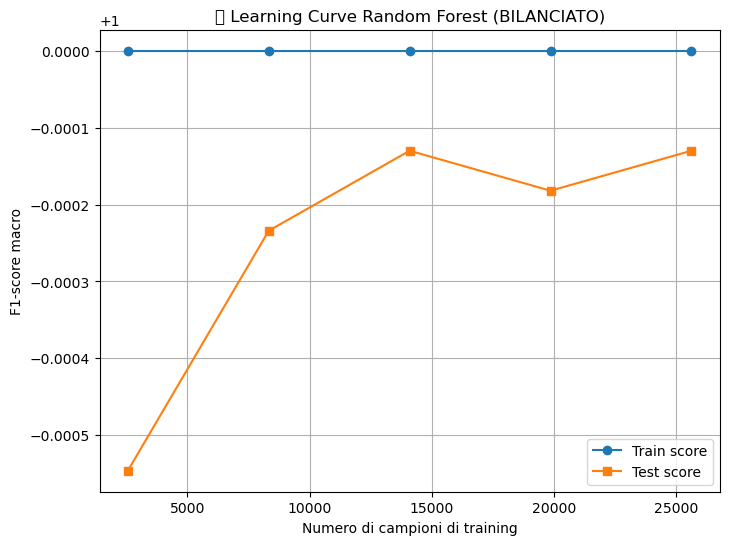


📊 **Confusion Matrix**: mostra come il modello classifica ciascuna classe.
- La diagonale principale indica le previsioni corrette.
- Valori fuori diagonale indicano errori di classificazione.
- Se è normalizzata, i valori sono percentuali di correttezza per classe.



<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


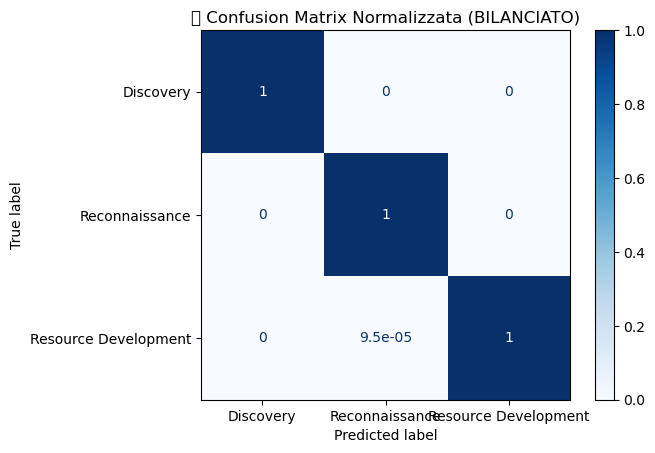


🎯 **Precision-Recall Curve (PR Curve)**:
- La precisione (asse Y) indica quante previsioni positive sono corrette.
- Il recall (asse X) indica quante istanze positive sono state trovate.
- Curve più in alto e più a destra → migliore capacità del modello di distinguere le classi.
- L’area sotto la curva (AP) riassume le prestazioni complessive.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


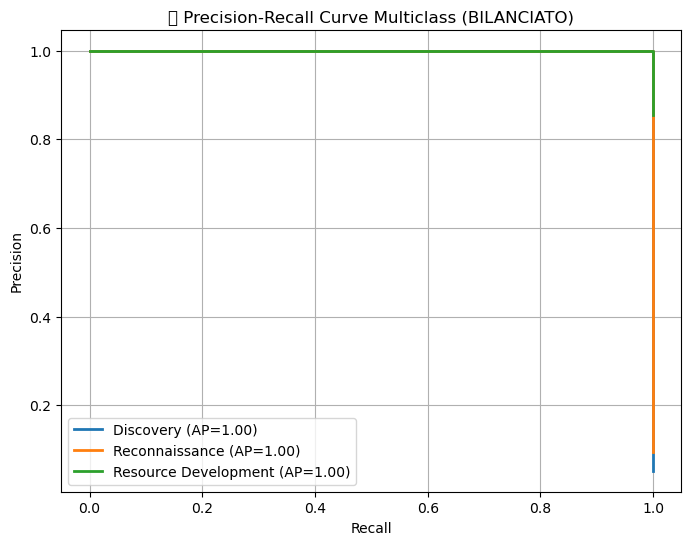


📈 **ROC Curve (Receiver Operating Characteristic)**:
- Mostra il compromesso tra *True Positive Rate* (sensibilità) e *False Positive Rate*.
- Curve più vicine al vertice superiore sinistro indicano prestazioni migliori.
- L’area sotto la curva (AUC) misura la qualità del modello: più è vicina a 1, meglio distingue le classi.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


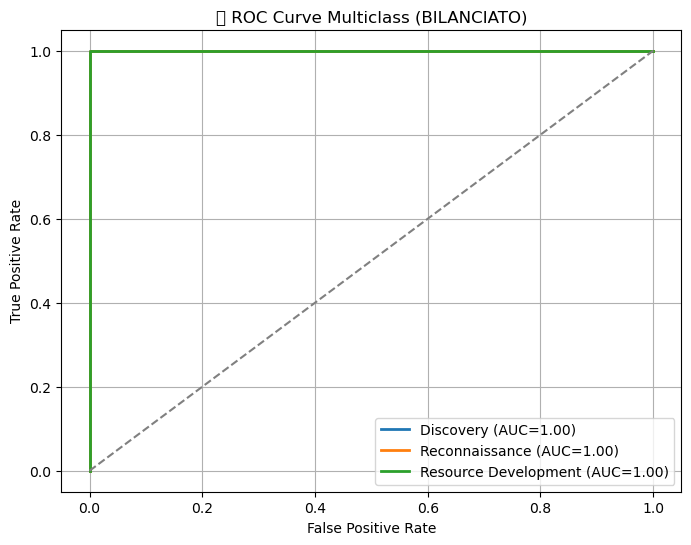


🌟 **Feature Importance**:
- Mostra quanto ciascuna variabile (latent feature) contribuisce alla decisione del modello.
- Valori più alti → feature più rilevanti.
- Utile per identificare le dimensioni latenti che influenzano maggiormente le predizioni.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


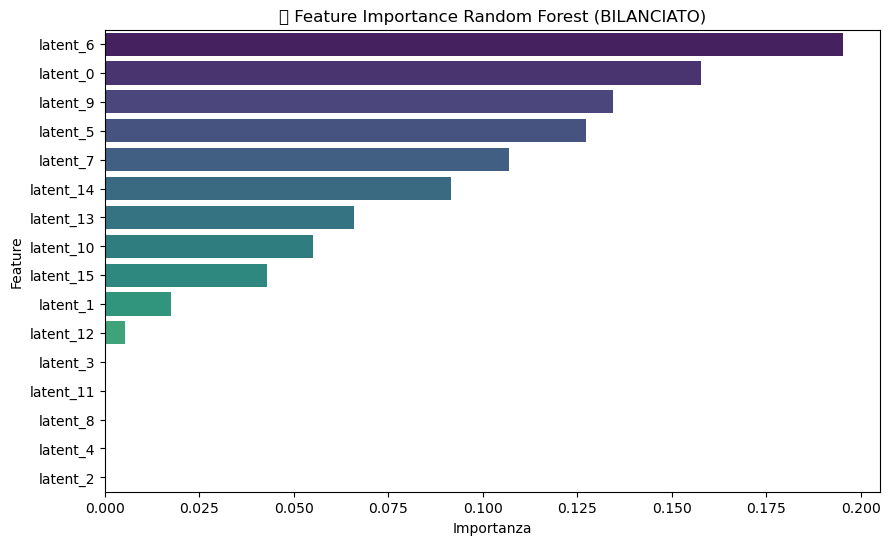


✅ Tutti i grafici e metriche avanzate generati con successo!


In [3]:
# ==========================================================
# BLOCCO 2b ✅ Metriche avanzate, grafici e interpretazione Random Forest
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

print("📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.\n"
      "- Una curva *train alta e test bassa* indica **overfitting** (il modello impara troppo bene i dati di training).\n"
      "- Curve vicine e stabili indicano **buona generalizzazione**.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train_bal, y_train_bal_str, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve Random Forest (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix**: mostra come il modello classifica ciascuna classe.\n"
      "- La diagonale principale indica le previsioni corrette.\n"
      "- Valori fuori diagonale indicano errori di classificazione.\n"
      "- Se è normalizzata, i valori sono percentuali di correttezza per classe.\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test_str, cmap='Blues', normalize='true'
)
plt.title("📊 Confusion Matrix Normalizzata (BILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision-Recall Curve multiclass
# ==========================================================
print("\n🎯 **Precision-Recall Curve (PR Curve)**:\n"
      "- La precisione (asse Y) indica quante previsioni positive sono corrette.\n"
      "- Il recall (asse X) indica quante istanze positive sono state trovate.\n"
      "- Curve più in alto e più a destra → migliore capacità del modello di distinguere le classi.\n"
      "- L’area sotto la curva (AP) riassume le prestazioni complessive.\n")

y_test_bin = label_binarize(y_test_str, classes=classes_str)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve multiclass
# ==========================================================
print("\n📈 **ROC Curve (Receiver Operating Characteristic)**:\n"
      "- Mostra il compromesso tra *True Positive Rate* (sensibilità) e *False Positive Rate*.\n"
      "- Curve più vicine al vertice superiore sinistro indicano prestazioni migliori.\n"
      "- L’area sotto la curva (AUC) misura la qualità del modello: più è vicina a 1, meglio distingue le classi.\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance
# ==========================================================
print("\n🌟 **Feature Importance**:\n"
      "- Mostra quanto ciascuna variabile (latent feature) contribuisce alla decisione del modello.\n"
      "- Valori più alti → feature più rilevanti.\n"
      "- Utile per identificare le dimensioni latenti che influenzano maggiormente le predizioni.\n")

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Random Forest (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici e metriche avanzate generati con successo!")


In [4]:
# ==========================================================
# BLOCCO 3 ✅ LightGBM (train bilanciato) con monitoraggio fold per fold
# versione pulita: usa DataFrame con nomi di feature coerenti
# ==========================================================
import numpy as np
import time
import pandas as pd
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

import lightgbm as lgb

print("🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con log pulito...\n")

# ==========================================================
# 0️⃣ Creazione DataFrame con nomi di feature coerenti
# ==========================================================
feature_names = [f'latent_{i}' for i in range(X_train_bal.shape[1])]
X_train_bal_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [10, -1],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100]
}

param_combinations = list(product(
    param_grid['num_leaves'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['n_estimators']
))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni...\n")

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (num_leaves, max_depth, lr, n_est) in enumerate(param_combinations, 1):
    params = {
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'learning_rate': lr,
        'n_estimators': n_est,
        'random_state': 42,
        'verbose': -1  # disattiva warning LightGBM
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal_df, y_train_bal), 1):
        X_tr, X_val = X_train_bal_df.iloc[train_idx], X_train_bal_df.iloc[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_lgb = lgb.LGBMClassifier(**best_params)
best_lgb.fit(X_train_bal_df, y_train_bal)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_lgb.predict(X_train_bal_df)
y_test_pred = best_lgb.predict(X_test_df)

train_f1 = print_metrics(y_train_bal, y_train_pred, "TRAIN", best_lgb.classes_)
test_f1 = print_metrics(y_test, y_test_pred, "TEST", best_lgb.classes_)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con log pulito...

🔍 Inizio GridSearch manuale su 16 combinazioni...

⚙️ Combinazione 1/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 50, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 0.9999
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 0.9997
✅ Combinazione 1 completata in 5.04s | F1 medio = 0.9999

⚙️ Combinazione 2/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 0.9999
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 0.9997
✅ Combinazione 2 completata in 3.68s | F1 medio = 0.9999

⚙️ Combinazione 3/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 0

🧩 Learning Curve (Curva di Apprendimento):
- Mostra come le prestazioni del modello cambiano al crescere del numero di campioni di training.
- Divario elevato tra training e test → possibile overfitting.
- Curve simili e alte → buona generalizzazione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


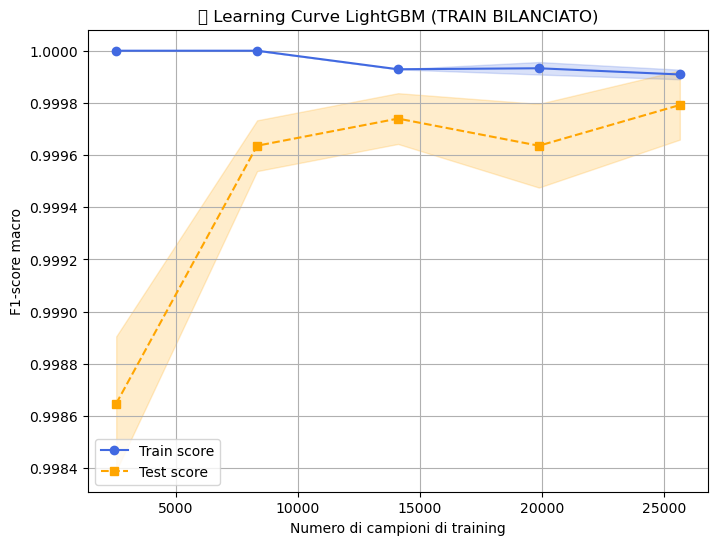

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



🌟 Feature Importance (Importanza delle Caratteristiche):
- Mostra quali latent features hanno maggiore impatto sulla predizione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


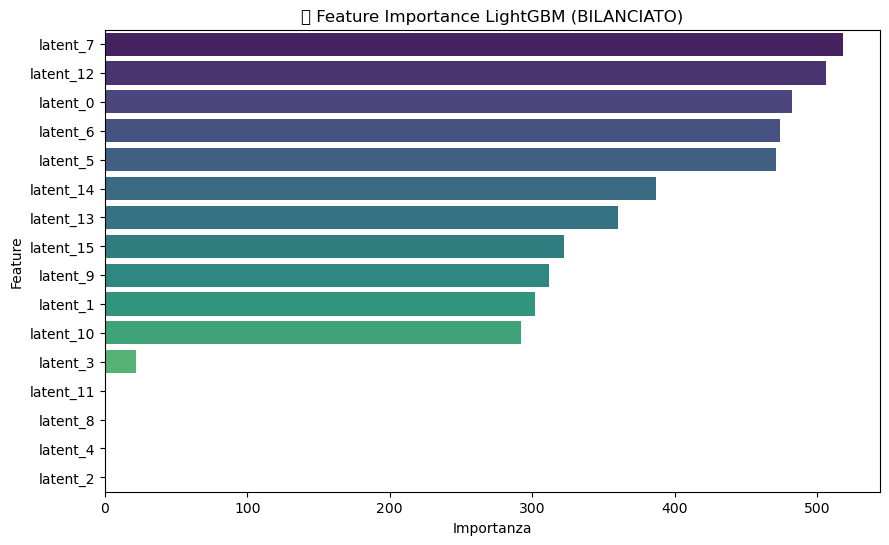

In [ ]:
# ==========================================================
# 6️⃣ Learning Curve LightGBM
# ==========================================================
print("🧩 Learning Curve (Curva di Apprendimento):\n"
      "- Mostra come le prestazioni del modello cambiano al crescere del numero di campioni di training.\n"
      "- Divario elevato tra training e test → possibile overfitting.\n"
      "- Curve simili e alte → buona generalizzazione.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_lgb, 
    X_train_bal_df,  # usa il DataFrame con nomi coerenti
    y_train_bal,     # label in stringhe
    cv=3, 
    scoring='f1_macro', 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score", color='royalblue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='royalblue')
plt.plot(train_sizes, test_mean, 's--', label="Test score", color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve LightGBM (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 🔟 Feature Importance
# ==========================================================
print("\n🌟 Feature Importance (Importanza delle Caratteristiche):\n"
      "- Mostra quali latent features hanno maggiore impatto sulla predizione.\n")

importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance LightGBM (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()


In [6]:
# ==========================================================
# BLOCCO XGBoost avanzato (TRAIN BILANCIATO) pulito
# ==========================================================
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

print("🏗️ Addestramento XGBoost avanzato (TRAIN BILANCIATO) con monitoraggio completo...\n")

# ==========================================================
# 1️⃣ Definizione di più set di parametri da testare
# ==========================================================
param_grid = [
    {'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8},
    {'max_depth': 6, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9},
    {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.7}
]

num_class = 3  # numero di classi
best_f1 = 0
best_params = None
best_model = None

# ==========================================================
# 2️⃣ Cross-validation 5-fold per ogni set di parametri
# ==========================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for params in param_grid:
    # Parametri completi per XGBoost
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': num_class,
        'gamma': 1.0,
        'min_child_weight': 3,
        'reg_alpha': 0.5,
        'reg_lambda': 2.0,
        'seed': 42,
        'eval_metric': 'mlogloss'
    }
    xgb_params.update(params)
    
    print(f"\n🔹 Parametri testati: {params}")
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal_enc), 1):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal_enc[train_idx], y_train_bal_enc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        evals = [(dval, 'val')]

        # Training senza verbose
        bst = xgb.train(xgb_params, dtrain, num_boost_round=300, evals=evals, verbose_eval=False)

        y_pred = np.argmax(bst.predict(dval), axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        cv_scores.append(f1)

        print(f"📈 Fold {fold:>2}/5 → F1_macro = {f1:.4f}")

    mean_f1 = np.mean(cv_scores)
    print(f"🏁 F1_macro medio: {mean_f1:.4f}")

    # Salva il miglior modello
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = params
        best_model = bst

# ==========================================================
# 3️⃣ TRAIN FINALE sul full train set con il miglior parametro
# ==========================================================
print(f"\n✅ Miglior set di parametri selezionato: {best_params}")

dtrain_full = xgb.DMatrix(X_train_bal, label=y_train_bal_enc)
dtest = xgb.DMatrix(X_test, label=y_test_enc)

final_model = xgb.train(
    {**xgb_params, **best_params},
    dtrain_full,
    num_boost_round=1000,
    evals=[(dtrain_full, 'train'), (dtest, 'eval')],
    early_stopping_rounds=30,
    verbose_eval=False  # niente log iterazione
)

# ==========================================================
# 4️⃣ Metriche su train e test
# ==========================================================
y_train_pred = np.argmax(final_model.predict(dtrain_full), axis=1)
y_test_pred = np.argmax(final_model.predict(dtest), axis=1)

def print_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")
    return f1

train_f1 = print_metrics(y_train_bal_enc, y_train_pred, "TRAIN")
test_f1 = print_metrics(y_test_enc, y_test_pred, "TEST")

gap = train_f1 - test_f1
if gap > 0.05:
    print(f"\n⚠️ Possibile overfitting: gap F1 = {gap:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile underfitting: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato senza over/underfitting evidente.")


🏗️ Addestramento XGBoost avanzato (TRAIN BILANCIATO) con monitoraggio completo...


🔹 Parametri testati: {'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8}
📈 Fold  1/5 → F1_macro = 0.9996
📈 Fold  2/5 → F1_macro = 1.0000
📈 Fold  3/5 → F1_macro = 1.0000
📈 Fold  4/5 → F1_macro = 1.0000
📈 Fold  5/5 → F1_macro = 0.9999
🏁 F1_macro medio: 0.9999

🔹 Parametri testati: {'max_depth': 6, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9}
📈 Fold  1/5 → F1_macro = 0.9997
📈 Fold  2/5 → F1_macro = 0.9997
📈 Fold  3/5 → F1_macro = 0.9999
📈 Fold  4/5 → F1_macro = 1.0000
📈 Fold  5/5 → F1_macro = 0.9997
🏁 F1_macro medio: 0.9998

🔹 Parametri testati: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.7}
📈 Fold  1/5 → F1_macro = 0.9996
📈 Fold  2/5 → F1_macro = 1.0000
📈 Fold  3/5 → F1_macro = 1.0000
📈 Fold  4/5 → F1_macro = 1.0000
📈 Fold  5/5 → F1_macro = 0.9997
🏁 F1_macro medio: 0.9999

✅ Miglior set di parametri selezionato: {'max_

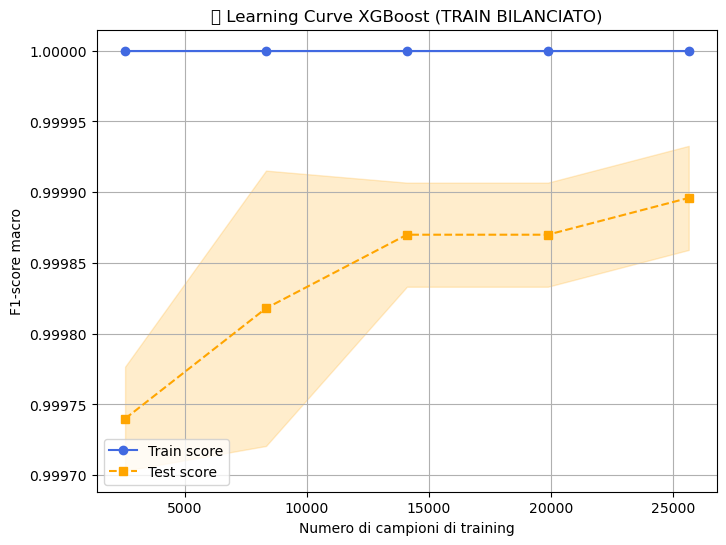

<Figure size 800x600 with 0 Axes>

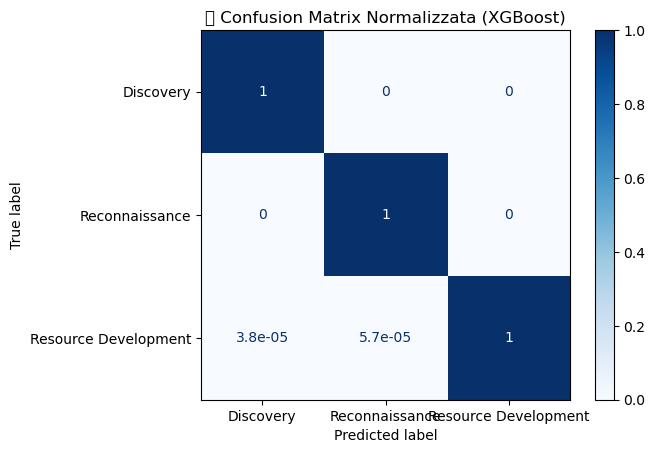

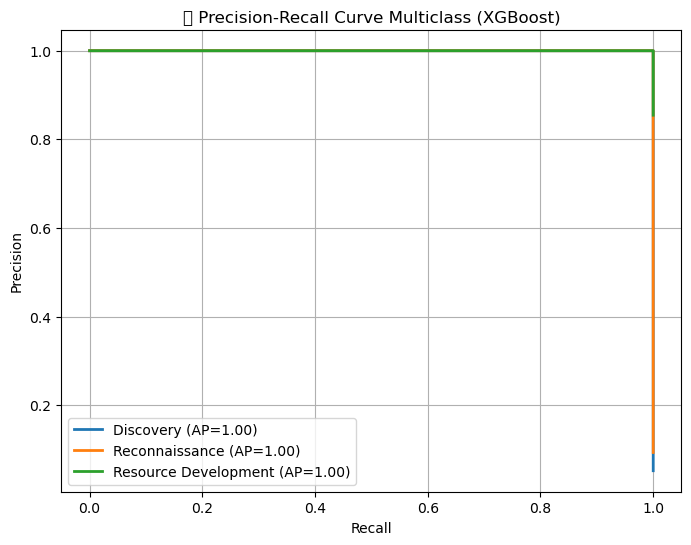

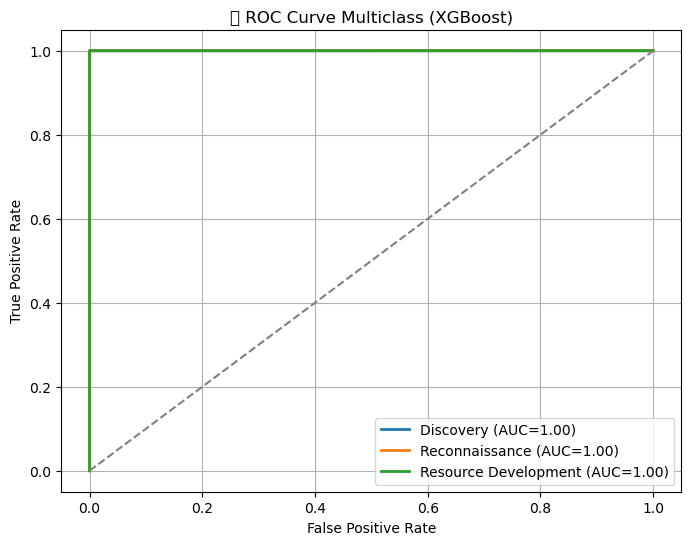

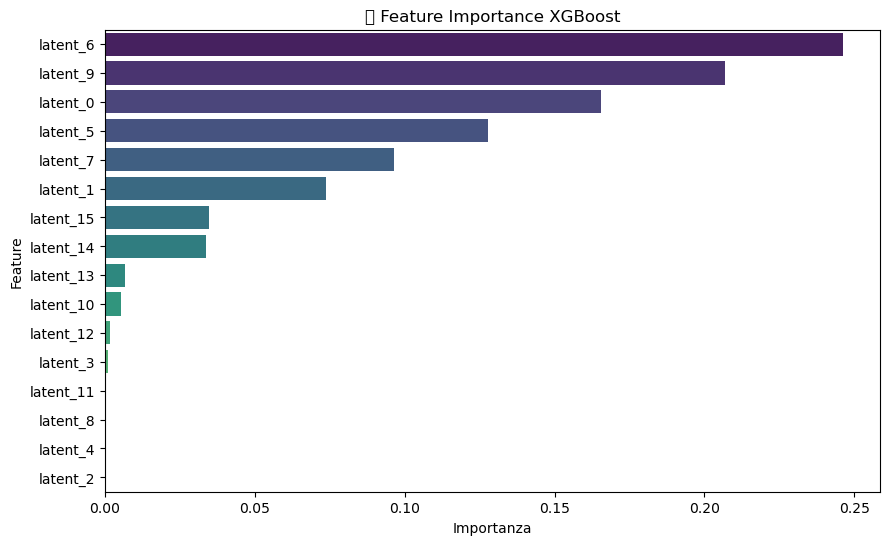


✅ Addestramento e grafici XGBoost completati con successo!


In [7]:
# ==========================================================
# 5️⃣ Learning Curve (usiamo XGBClassifier addestrato su full training per compatibilità)
# ==========================================================
from sklearn.model_selection import learning_curve

# Creiamo un XGBClassifier con gli stessi parametri già usati
model_xgb_clf = xgb.XGBClassifier(
    max_depth=params['max_depth'],
    learning_rate=params['learning_rate'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    n_estimators=final_model.best_iteration+1,  # numero di round ottimale
    use_label_encoder=False,
    eval_metric='mlogloss'
)
model_xgb_clf.fit(X_train_bal, y_train_bal_enc)

train_sizes, train_scores, test_scores = learning_curve(
    model_xgb_clf,
    X_train_bal,
    y_train_bal_enc,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score", color='royalblue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='royalblue')
plt.plot(train_sizes, test_mean, 's--', label="Test score", color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve XGBoost (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 6️⃣ Confusion Matrix, PR, ROC e Feature Importance
# ==========================================================
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize

class_labels = [0, 1, 2]  # usa gli indici delle classi
class_names = ['Discovery', 'Reconnaissance', 'Resource Development']

# Confusion Matrix
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    model_xgb_clf,
    X_test,
    y_test_enc,
    cmap='Blues',
    normalize='true',
    display_labels=class_names
)
plt.title("📊 Confusion Matrix Normalizzata (XGBoost)")
plt.show()

# Precision-Recall Curve
y_test_bin = label_binarize(y_test_enc, classes=class_labels)
y_score = model_xgb_clf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls_name} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls_name} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
importances = model_xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance XGBoost")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Addestramento e grafici XGBoost completati con successo!")


In [8]:
# ==========================================================
# BLOCCO MLP avanzato (TRAIN BILANCIATO) con monitoraggio completo e confronto parametri
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

print("🏗️ Addestramento MLP avanzato (TRAIN BILANCIATO) con monitoraggio completo...\n")

# ==========================================================
# 1️⃣ Standardizzazione
# ==========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# ==========================================================
# 2️⃣ Grid di parametri da confrontare
# ==========================================================
param_grid = [
    {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'learning_rate_init': 0.0005}
]

# ==========================================================
# 3️⃣ Cross-validation 5-fold per ogni set di parametri
# ==========================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_params = None
best_f1 = 0
best_model = None

for params in param_grid:
    mlp = MLPClassifier(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        alpha=params['alpha'],
        learning_rate_init=params['learning_rate_init'],
        activation='relu',
        solver='adam',
        batch_size=32,
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=30,
        random_state=42,
        verbose=False
    )
    print(f"\n🔹 Parametri testati: {params}")
    
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train_bal_enc), 1):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_bal_enc[train_idx], y_train_bal_enc[val_idx]

        mlp.fit(X_tr, y_tr)
        preds = mlp.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        cv_scores.append(f1)
        print(f"📈 Fold {fold:>2}/5 → F1_macro = {f1:.4f}")
    
    mean_f1 = np.mean(cv_scores)
    std_f1 = np.std(cv_scores)
    print(f"🏁 F1_macro medio: {mean_f1:.4f} ± {std_f1:.4f}")
    
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = params
        best_model = mlp

# ==========================================================
# 4️⃣ Training finale con il miglior set di parametri
# ==========================================================
print(f"\n✅ Miglior set di parametri selezionato: {best_params}")
best_model.fit(X_train_scaled, y_train_bal_enc)

# ==========================================================
# 5️⃣ Metriche su train e test
# ==========================================================
def print_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")
    return f1

y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_f1 = print_metrics(y_train_bal_enc, y_train_pred, "TRAIN")
test_f1 = print_metrics(y_test_enc, y_test_pred, "TEST")

# Gap F1 per over/underfitting
gap = train_f1 - test_f1
if gap > 0.05:
    print(f"\n⚠️ Possibile overfitting: gap F1 = {gap:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile underfitting: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato senza over/underfitting evidente.")


🏗️ Addestramento MLP avanzato (TRAIN BILANCIATO) con monitoraggio completo...


🔹 Parametri testati: {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.001}
📈 Fold  1/5 → F1_macro = 0.9995
📈 Fold  2/5 → F1_macro = 1.0000
📈 Fold  3/5 → F1_macro = 0.9997
📈 Fold  4/5 → F1_macro = 0.9999
📈 Fold  5/5 → F1_macro = 0.9997
🏁 F1_macro medio: 0.9998 ± 0.0002

🔹 Parametri testati: {'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'learning_rate_init': 0.001}
📈 Fold  1/5 → F1_macro = 0.9993
📈 Fold  2/5 → F1_macro = 0.9999
📈 Fold  3/5 → F1_macro = 0.9997
📈 Fold  4/5 → F1_macro = 0.9995
📈 Fold  5/5 → F1_macro = 0.9997
🏁 F1_macro medio: 0.9996 ± 0.0002

🔹 Parametri testati: {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'learning_rate_init': 0.0005}
📈 Fold  1/5 → F1_macro = 0.9993
📈 Fold  2/5 → F1_macro = 0.9999
📈 Fold  3/5 → F1_macro = 0.9999
📈 Fold  4/5 → F1_macro = 0.9997
📈 Fold  5/5 → F1_macro = 0.9997
🏁 F1_macro medio: 0.9997 ± 0.0002

✅ Miglior set di parametri selezio

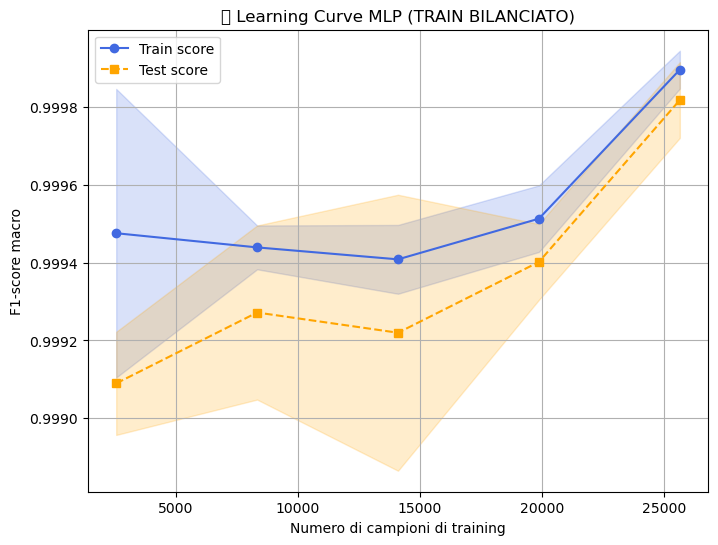

<Figure size 800x600 with 0 Axes>

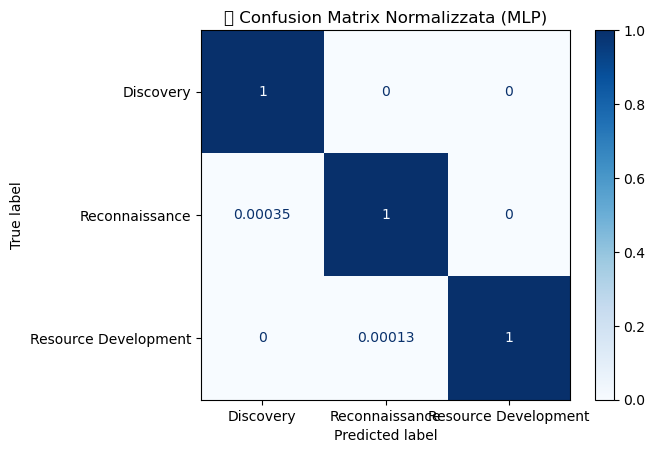

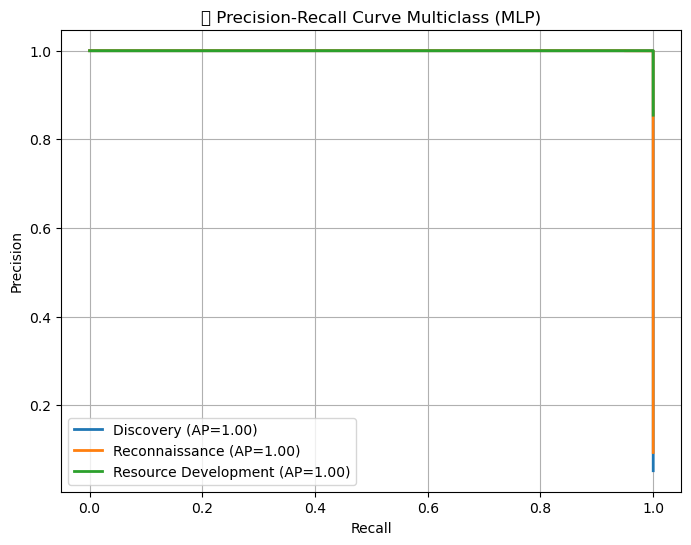

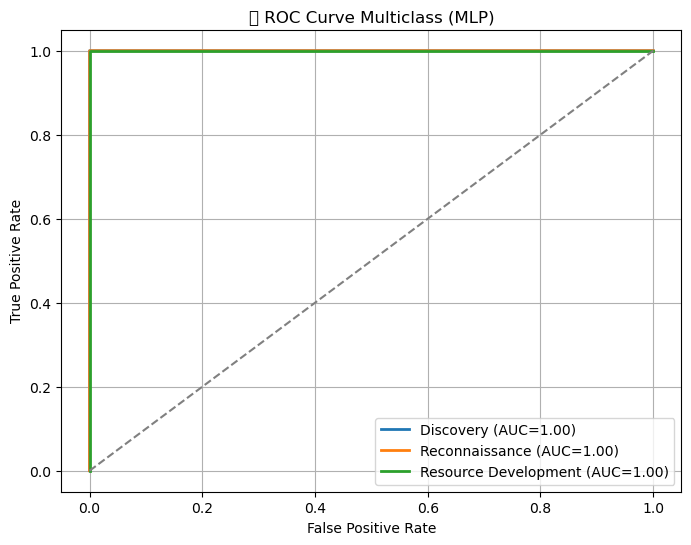

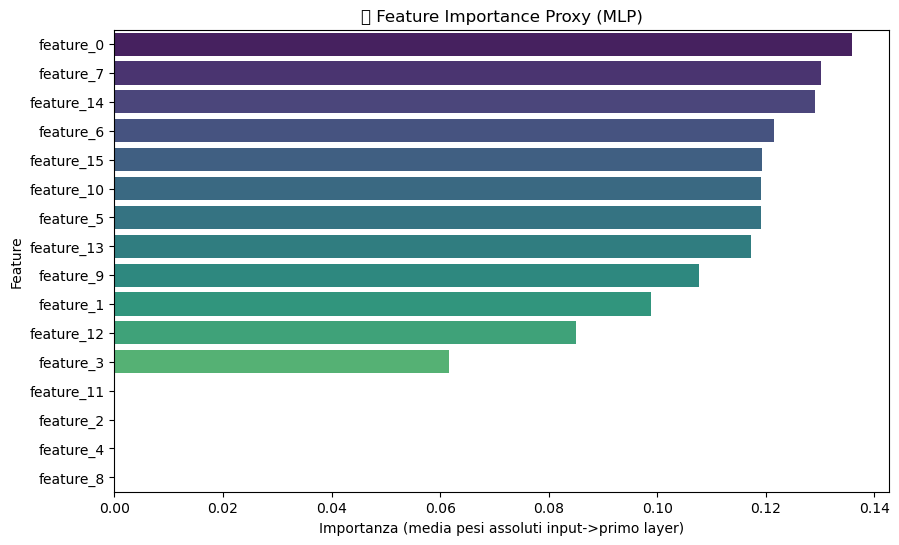

In [9]:
import seaborn as sns

# ==========================================================
# 6️⃣ Grafici per MLP
# ==========================================================
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score

# Classi
class_labels = [0, 1, 2]
class_names = ['Discovery', 'Reconnaissance', 'Resource Development']

# ==========================================================
# Learning Curve
# ==========================================================
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_scaled,
    y_train_bal_enc,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score", color='royalblue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='royalblue')
plt.plot(train_sizes, test_mean, 's--', label="Test score", color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve MLP (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Confusion Matrix
# ==========================================================
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_scaled,
    y_test_enc,
    cmap='Blues',
    normalize='true',
    display_labels=class_names
)
plt.title("📊 Confusion Matrix Normalizzata (MLP)")
plt.show()

# ==========================================================
# Precision-Recall Curve
# ==========================================================
y_test_bin = label_binarize(y_test_enc, classes=class_labels)
y_score = best_model.predict_proba(X_test_scaled)

plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls_name} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (MLP)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# ROC Curve
# ==========================================================
plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls_name} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (MLP)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Feature Importance (proxy MLP)
# ==========================================================

# Appiattiamo tutti i pesi di input->primo layer come proxy delle feature
importances = np.mean(np.abs(best_model.coefs_[0]), axis=1)  # media assoluta dei pesi in ingresso a ogni feature
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'feature_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Proxy (MLP)")
plt.xlabel("Importanza (media pesi assoluti input->primo layer)")
plt.ylabel("Feature")
plt.show()



,Train F1,Test F1,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
RandomForest,1.0000,0.9998,1.0000,0.9999,1.0000,0.9997,1.0000,1.0000
LightGBM,0.9999,0.9994,0.9999,0.9997,0.9999,0.9990,0.9999,0.9998
XGBoost,0.9999,0.9997,0.9999,0.9999,0.9999,0.9994,0.9999,1.0000
MLP,0.4695,0.5855,0.5724,0.9214,0.4343,0.6062,0.5724,0.5723



🔍 Analisi comparativa delle Feature Importance tra modelli:

Top 10 feature per RandomForest:


,Feature,RandomForest
6,latent_6,0.195198
0,latent_0,0.157799
9,latent_9,0.134289
5,latent_5,0.127252
7,latent_7,0.107009
14,latent_14,0.091481
13,latent_13,0.066021
10,latent_10,0.055079
15,latent_15,0.042924
1,latent_1,0.017578



Top 10 feature per LightGBM:


,Feature,LightGBM
7,latent_7,0.116457
12,latent_12,0.113759
0,latent_0,0.108363
6,latent_6,0.106565
5,latent_5,0.105890
14,latent_14,0.087005
13,latent_13,0.080935
15,latent_15,0.072392
9,latent_9,0.070144
1,latent_1,0.067896



Top 10 feature per XGBoost:


,Feature,XGBoost
6,latent_6,0.246147
9,latent_9,0.206870
0,latent_0,0.165628
5,latent_5,0.127851
7,latent_7,0.096505
1,latent_1,0.073845
15,latent_15,0.034708
14,latent_14,0.033673
13,latent_13,0.006741
10,latent_10,0.005349



Top 10 feature per MLP (proxy):


,Feature,MLP (proxy)
0,latent_0,0.101108
7,latent_7,0.096807
14,latent_14,0.095953
6,latent_6,0.090399
15,latent_15,0.088683
10,latent_10,0.088604
5,latent_5,0.088507
13,latent_13,0.087233
9,latent_9,0.080086
1,latent_1,0.073489


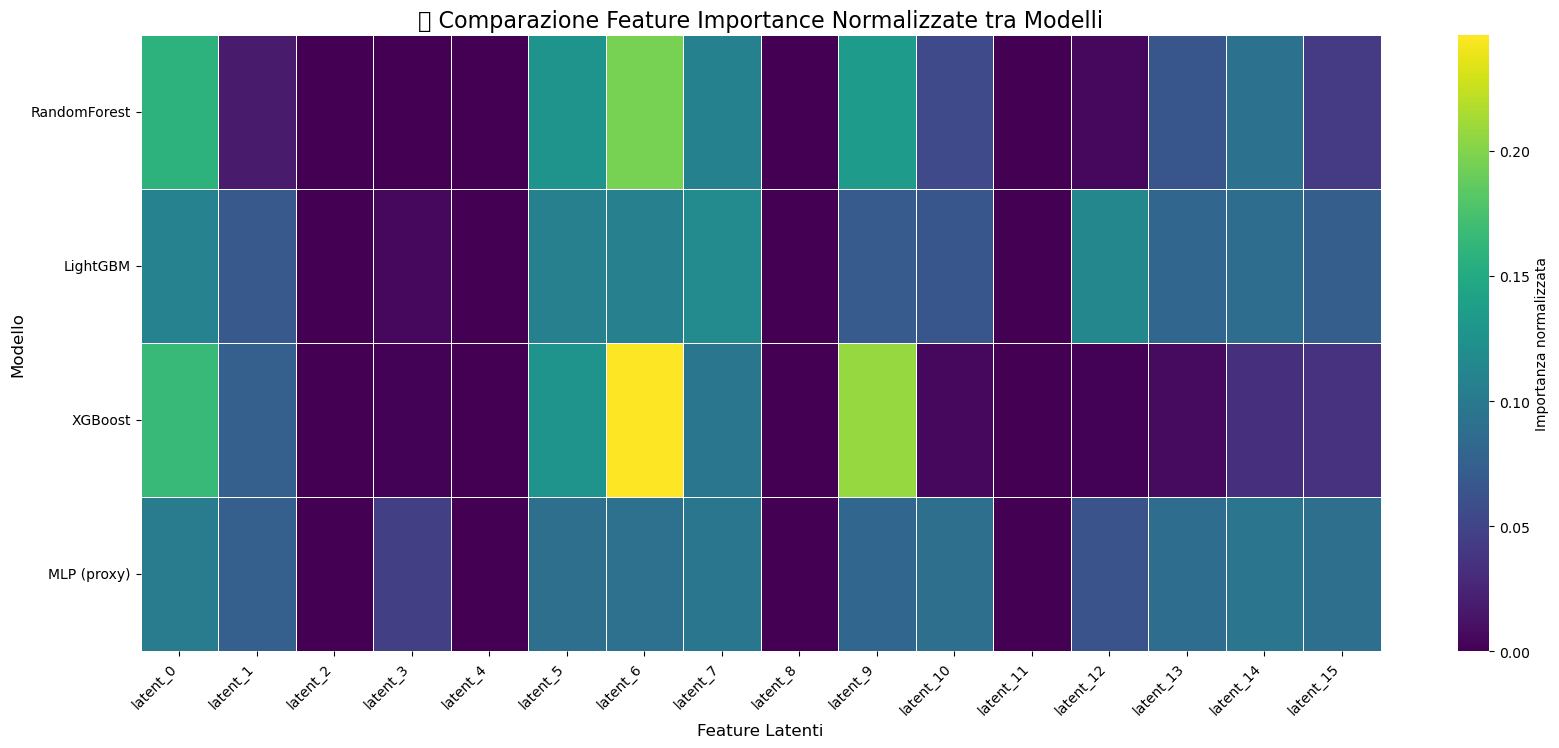


🎨 Come interpretare la heatmap:
- Ogni riga rappresenta un modello (RF, LightGBM, XGBoost, MLP)
- Ogni colonna rappresenta una feature latente
- Più il colore è intenso → maggiore importanza della feature per quel modello
- Le differenze nei pattern di colore mostrano come i modelli apprendono segnali diversi dai dati

💡 Analisi interpretativa basata sui risultati ottenuti:

🔹 Random Forest:
- Evidenzia in modo marcato latent_6, latent_0 e latent_9 come feature dominanti
- Ha una distribuzione leggermente più bilanciata rispetto a XGBoost, ma con pochi driver principali

🔹 LightGBM:
- Mostra una distribuzione delle importanze più omogenea e meno polarizzata
- Anche qui emergono latent_7, latent_12, latent_0, latent_6 e latent_5
- Evidenzia più feature rilevanti rispetto agli altri algoritmi boosting

🔹 XGBoost:
- Molto focalizzato su poche feature dominanti: latent_6, latent_9, latent_0 e latent_5
- Pattern più aggressivo rispetto a LightGBM → segnala forte dipendenza da driver princi

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import xgboost as xgb

# Assumiamo che classes_str sia la lista delle classi in stringhe,
# ad es. classes_str = ['Discovery', 'Reconnaissance', 'Resource Development']
# se non esiste, definiscila come hai fatto prima.
# Fitta il LabelEncoder sulle classi stringa (ordine coerente)
le = LabelEncoder()
le.fit(classes_str)

def ensure_encoded(y, le):
    """
    Se y contiene stringhe, le.transform; se già numerico (int), lo restituisce come int array.
    """
    y = np.asarray(y)
    if y.dtype.type is np.str_ or isinstance(y.flat[0], str):
        return le.transform(y)
    else:
        # garantiamo int array (es. numpy)
        return y.astype(int)

def preds_to_encoded(preds, model_name, le):
    """
    Converte le predizioni del modello in etichette codificate numericamente.
    - preds può essere array di stringhe oppure array di numeri.
    - Per sicurezza, se preds sono probabilità, si fa argmax esterno (ma normalmente passiamo già pred class).
    """
    preds = np.asarray(preds)
    # se preds sono probabilità (shape NxC), argmax
    if preds.ndim == 2:
        preds = np.argmax(preds, axis=1)
        return preds.astype(int)
    # se sono stringhe, trasformale
    if preds.dtype.type is np.str_ or isinstance(preds.flat[0], str):
        return le.transform(preds)
    else:
        return preds.astype(int)

def calc_metrics(model_name, model, X_train, y_train, X_test, y_test):
    # y_train, y_test possono essere stringhe o encoded: convertiamoli a numerici coerenti
    y_train_enc = ensure_encoded(y_train, le)
    y_test_enc = ensure_encoded(y_test, le)

    # ottieni predizioni coerenti (numeriche)
    if model_name == "XGBoost":
        # final_model sembra essere un booster: usa DMatrix e predict -> probabilità o logits -> argmax
        y_train_pred = np.argmax(model.predict(xgb.DMatrix(X_train)), axis=1)
        y_test_pred = np.argmax(model.predict(xgb.DMatrix(X_test)), axis=1)
    else:
        # modelli sklearn-like restituiscono class labels (stringhe o int)
        y_train_pred_raw = model.predict(X_train)
        y_test_pred_raw = model.predict(X_test)

        y_train_pred = preds_to_encoded(y_train_pred_raw, model_name, le)
        y_test_pred = preds_to_encoded(y_test_pred_raw, model_name, le)

    metrics = {
        "Train F1": f1_score(y_train_enc, y_train_pred, average='macro'),
        "Test F1": f1_score(y_test_enc, y_test_pred, average='macro'),
        "Train Accuracy": accuracy_score(y_train_enc, y_train_pred),
        "Test Accuracy": accuracy_score(y_test_enc, y_test_pred),
        "Train Precision": precision_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        "Test Precision": precision_score(y_test_enc, y_test_pred, average='macro', zero_division=0),
        "Train Recall": recall_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        "Test Recall": recall_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
    }
    return metrics

# ----------------------------------------------------------
# Usa calc_metrics nello stesso ciclo che già avevi
# Assicurati di passare ai modelli i dati CORRETTI (X_train_bal, y_train_bal in la forma corrispondente)
# Qui mostro il loop aggiornato:
# ----------------------------------------------------------
models = {
    "RandomForest": best_rf,
    "LightGBM": best_lgb,
    "XGBoost": final_model,
    "MLP": best_model
}

summary = {}
for name, model in models.items():
    # Nota: ora calc_metrics si occupa della coerenza delle label
    summary[name] = calc_metrics(name, model, X_train_bal, y_train_bal_enc, X_test, y_test_enc)

df_summary = pd.DataFrame(summary).T
display(df_summary.round(4))

# ==========================================================
# 🔍 Analisi comparativa delle Feature Importance
# ==========================================================
print("\n🔍 Analisi comparativa delle Feature Importance tra modelli:")

# Creiamo un DataFrame per confrontare le feature importance
import pandas as pd

feature_names = [f'latent_{i}' for i in range(X_train_bal.shape[1])]

# Random Forest
rf_importances = best_rf.feature_importances_
# LightGBM
lgb_importances = best_lgb.feature_importances_
# XGBoost
xgb_importances = model_xgb_clf.feature_importances_
# MLP (proxy media pesi input->primo layer)
mlp_importances = np.mean(np.abs(best_model.coefs_[0]), axis=1)

df_feat = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest': rf_importances,
    'LightGBM': lgb_importances,
    'XGBoost': xgb_importances,
    'MLP (proxy)': mlp_importances
})

# Normalizziamo per avere tutte le importanze tra 0 e 1
df_feat_norm = df_feat.copy()
for col in ['RandomForest','LightGBM','XGBoost','MLP (proxy)']:
    df_feat_norm[col] = df_feat_norm[col] / df_feat_norm[col].sum()

# Visualizziamo le prime 10 feature più rilevanti per ciascun modello
top_n = 10
for model_col in ['RandomForest','LightGBM','XGBoost','MLP (proxy)']:
    print(f"\nTop {top_n} feature per {model_col}:")
    display(df_feat_norm[['Feature', model_col]].sort_values(model_col, ascending=False).head(top_n))

# Heatmap comparativa solo colori
plt.figure(figsize=(20,8))  # dimensione ampia per leggere bene le feature
sns.heatmap(
    df_feat_norm.set_index('Feature').T,
    cmap="viridis",
    annot=False,       # disattiviamo i valori numerici
    linewidths=0.5,   # linee tra le celle per chiarezza
    cbar_kws={'label': 'Importanza normalizzata'}
)
plt.title("🌟 Comparazione Feature Importance Normalizzate tra Modelli", fontsize=16)
plt.ylabel("Modello", fontsize=12)
plt.xlabel("Feature Latenti", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


print("\n🎨 Come interpretare la heatmap:")
print("- Ogni riga rappresenta un modello (RF, LightGBM, XGBoost, MLP)")
print("- Ogni colonna rappresenta una feature latente")
print("- Più il colore è intenso → maggiore importanza della feature per quel modello")
print("- Le differenze nei pattern di colore mostrano come i modelli apprendono segnali diversi dai dati\n")

print("💡 Analisi interpretativa basata sui risultati ottenuti:\n")

print("🔹 Random Forest:")
print("- Evidenzia in modo marcato latent_6, latent_0 e latent_9 come feature dominanti")
print("- Ha una distribuzione leggermente più bilanciata rispetto a XGBoost, ma con pochi driver principali\n")

print("🔹 LightGBM:")
print("- Mostra una distribuzione delle importanze più omogenea e meno polarizzata")
print("- Anche qui emergono latent_7, latent_12, latent_0, latent_6 e latent_5")
print("- Evidenzia più feature rilevanti rispetto agli altri algoritmi boosting\n")

print("🔹 XGBoost:")
print("- Molto focalizzato su poche feature dominanti: latent_6, latent_9, latent_0 e latent_5")
print("- Pattern più aggressivo rispetto a LightGBM → segnala forte dipendenza da driver principali\n")

print("🔹 MLP (proxy pesi layer 1):")
print("- Distribuzione molto più uniforme rispetto ai modelli ad alberi")
print("- Evidenzia latent_0, latent_7, latent_14 e latent_6 come principali, ma con differenze meno drastiche")
print("- Conferma che la rete neurale apprende segnali più diffusi e meno interpretabili\n")

print("🧠 Sintesi finale:")
print("- Tutti i modelli concordano sull'importanza di latent_0, latent_6 e latent_7 → feature robuste")
print("- XGBoost ha la maggiore concentrazione su poche feature (approccio aggressive boosting)")
print("- LightGBM distribuisce meglio le importanze, indicando generalizzazione più ampia")
print("- MLP distribuisce l'importanza su molte feature → apprendimento più complesso e meno spiegabile")
print("- Questa coerenza tra modelli rafforza la fiducia nelle feature condivise come driver principali\n")
